<a href="https://colab.research.google.com/github/kavyajeetbora/end_to_end_gee_with_python/blob/master/end_to_end_earth_engine/Module_03_Supervised_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 3: Supervised Classification

## Introduction to Machine Learning and Supervised Classification

Supervised classification is arguably the most important classical machine learning techniques in remote sensing. Applications range from generating Land Use/Land Cover maps to change detection. Google Earth Engine is unique suited to do supervised classification at scale. The interactive nature of Earth Engine development allows for iterative development of supervised classification workflows by combining many different datasets into the model. This module covers basic supervised classification workflow, accuracy assessment, hyperparameter tuning and change detection


01. Basic Supervised Classification
02. Accuracy Assessment
03. Improving the Classification
04. Exporting Classification Results
05. Calculating Area

In [1]:
import ee
import geemap
import seaborn as sns
import pandas as pd

ee.Authenticate()
ee.Initialize(project='kavyajeetbora-ee')

## Basic Supervised Classification

- We will learn how to do a basic land cover classification using training - samples collected from the Code Editor using the High Resolution basemap imagery provided by Google Maps.
- This method requires no prior training data and is quite effective to generate high quality classification samples anywhere in the world.
- The goal is to classify each source pixel into one of the following classes - urban, bare, water or vegetation.
- Using the drawing tools in the code editor, you create 4 new feature collection with points representing pixels of that class.
- Each feature collection has a property called landcover with values of 0, 1, 2 or 3 indicating whether the feature collection represents urban, bare, water or vegetation respectively.
- We then train a Random Forest classifier using these training set to build a model and apply it to all the pixels of the image to create a 4 class image

**Fun fact**: The classifiers in Earth Engine API have names starting with smile - such as ee.Classifier.smileRandomForest(). The smile part refers to the [Statistical Machine Intelligence and Learning Engine (SMILE)](https://haifengl.github.io/index.html) JAVA library which is used by Google Earth Engine to implement these algorithms.

<img src="https://courses.spatialthoughts.com/images/end_to_end_gee/classified.png" height=300/>

### Load the geomtry of area of interest:

In [2]:
bangalore = ee.FeatureCollection('users/ujavalgandhi/public/bangalore_boundary')
geometry = bangalore.geometry()
bangalore.size()

### Load the sentinel image

The band values will be used as the input properties for the classifier

In [3]:
## Get the sentinel image collection
s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED')

## Filter the image collection
filtered = s2.filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE",30))\
.filter(ee.Filter.date('2023-01-01','2024-01-01'))\
.filter(ee.Filter.bounds(geometry))

filtered.size()

Since this is a image collection, convert it to a composite using `median()`

In [4]:
## create a composite and clip it as per geometry
median = filtered.median().clip(geometry)

### Load the GCPs
Now load the gcps (ground control points) that are labelled with the correct class: urban, water, bare and vegetation

In [5]:
## Load the training data with lables
## basically a point geometry with a class value store as property: 'landcover'
urban = ee.FeatureCollection('users/ujavalgandhi/e2e/urban_gcps')
water = ee.FeatureCollection('users/ujavalgandhi/e2e/water_gcps')
bare = ee.FeatureCollection('users/ujavalgandhi/e2e/bare_gcps')
vegetation = ee.FeatureCollection('users/ujavalgandhi/e2e/vegetation_gcps')

## Now merge the data into one single table
gcps = urban.merge(water).merge(bare).merge(vegetation)
## Viewing the first gcp
gcps.getInfo()['features'][0]

{'type': 'Feature',
 'geometry': {'type': 'Point',
  'coordinates': [77.65618319730623, 12.954774480921643]},
 'id': '1_1_1_00000000000000000000',
 'properties': {'landcover': 0}}

### Prepare the training data

In [6]:
## Prepare the training data
## we need to merge the pixel values from sentinel image with the class values
## The band values from sentinel will be the input values
## and gcps landcover property will be the output class
training = median.sampleRegions(
    collection = gcps,
    properties = ['landcover'],
    scale=100
)

Here the all the bands are the input characteristics of the pixel and 'landcover' value is the class that determines whether it is urban, water, bare or vegetation

### Plot the training data on a map

In [7]:
## Plot on map
vizParams = {
    'min': 0,
    'max': 3000,
    'bands': ['B4', 'B3', "B2"]
}

Map = geemap.Map()
Map.addLayer(median, vizParams, name='Sentinel')
Map.addLayer(gcps, {'color':'red'})
Map.centerObject(geometry, zoom=12)

Map

Map(center=[12.978777310922773, 77.60355759502113], controls=(WidgetControl(options=['position', 'transparent_…

### Train a classifier

We will use a random forest model for training

In [8]:
classifier = ee.Classifier.smileRandomForest(50)
classifier

train the model

In [9]:
classifier = classifier.train(
    features= training,
    classProperty = 'landcover',
    inputProperties = median.bandNames()
)

classifier

In [10]:
classified = median.classify(classifier)

In [11]:
palette = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
visParams = {
    'min': 0,
    'max':3,
    'palette': palette
}

Map = geemap.Map()
Map.addLayer(classified, visParams, name="prediction")
Map.centerObject(geometry, zoom=12)
Map

Map(center=[12.978777310922773, 77.60355759502113], controls=(WidgetControl(options=['position', 'transparent_…

Filter the water area

In [12]:
water = classified.eq(2)
Map = geemap.Map()
Map.addLayer(water, visParams, name="water")
Map.centerObject(geometry, zoom=12)
Map

Map(center=[12.978777310922773, 77.60355759502113], controls=(WidgetControl(options=['position', 'transparent_…

Reference
1. [Module 4 - 01 Basic Supervised Classification - GEE for Water Resources Management](https://youtu.be/Karfbita0Qo?si=M_UpqyqY-mgrGQ3Y)

2. [Module 4 - 03 Accuracy Assessment - GEE for Water Resources Management](https://youtu.be/erwxur0HMao?si=STjsgdeVvJZ7-RzW)

## Accuracy Assessment

It is important to get a quantitative estimate of the accuracy of the classification. To do this, a common strategy is to divide your training samples into 2 random fractions - one used for training the model and the other for validation of the predictions. Once a classifier is trained, it can be used to classify the entire image. We can then compare the classified values with the ones in the validation fraction. We can use the ee.Classifier.confusionMatrix() method to calculate a Confusion Matrix representing expected accuracy.

Classification results are evaluated based on the following metrics

- Overall Accuracy: How many samples were classified correctly.
- Producer’s Accuracy: How well did the classification predict each class.
- Consumer’s Accuracy (Reliability): How reliable is the prediction in each class.
- Kappa Coefficient: How well the classification performed as compared to random assignment.

<img src='https://courses.spatialthoughts.com/images/end_to_end_gee/accuracy_assessment.png' height=300/>

In [13]:
## Load the sentinel image collection
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

## Load the HydroSHEDS dataset
basin = ee.FeatureCollection('WWF/HydroSHEDS/v1/Basins/hybas_7')

## Load the training dataset with labels
gcp = ee.FeatureCollection('users/ujavalgandhi/e2e/arkavathy_gcps')

gcp.size()

In [14]:
arkavathy = basin.filter(ee.Filter.eq('HYBAS_ID', 4071139640))
geometry = arkavathy.geometry()

In [15]:
rgbVis = {
    'min': 0,
    'max': 3000,
    'bands': ['B4', 'B3', 'B2']
}

filtered = s2.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))\
.filter(ee.Filter.date('2023-01-01','2024-01-01'))\
.filter(ee.Filter.bounds(geometry)).select('B.*')

composite = filtered.median()

Map = geemap.Map()
Map.addLayer(composite.clip(geometry), rgbVis, 'image')
Map.centerObject(geometry, zoom=10)
Map

Map(center=[12.8376291976128, 77.44795130277099], controls=(WidgetControl(options=['position', 'transparent_bg…

Preparing the data for training

In [16]:
## Create a random column which will assign a float number to each feature with uniform distribution
gcps = gcp.randomColumn()
train_test_split = 0.8
trainGCP = gcps.filter(ee.Filter.lt('random', train_test_split))
testGCP = gcps.filter(ee.Filter.gte('random',train_test_split))

print('Training data size', len(trainGCP.getInfo()['features']))
print('Test data size', len(testGCP.getInfo()['features']))

Training data size 359
Test data size 88


while overlaying the GCP points over the image,  you may get an error like this:

```python
EEException: Output of image computation is too large (12 bands for 936000 pixels = 85.7 MiB > 80.0 MiB).
If this is a reduction, try specifying a larger 'tileScale' parameter.
```

The error message you're encountering indicates that the output of an image computation operation is too large. Specifically, it seems that you're trying to compute an image with 12 bands for 936,000 pixels, resulting in a size of 85.7 MiB, which exceeds the maximum allowed size of 80.0 MiB.

The `tileScale` parameter controls the size of the individual tiles used in the computation process, and increasing it can help reduce memory usage

By increasing the `tileScale`, you're essentially splitting the computation into smaller tiles, which can help reduce memory usage and avoid the error.

In [17]:
## Now overlay the gcp points on the image to get the training inputs
## Currently the points are only having the class labels
training = composite.sampleRegions(
    collection = trainGCP,
    properties = ['landcover'],
    scale=10,
    tileScale=16
)

In [18]:
## Print out a sample training input
training.getInfo()['features'][0]

{'type': 'Feature',
 'geometry': None,
 'id': '000000000000000000af_0',
 'properties': {'B1': 1329,
  'B11': 4034,
  'B12': 4388,
  'B2': 2024,
  'B3': 2344,
  'B4': 2518,
  'B5': 2547,
  'B6': 2545,
  'B7': 2511,
  'B8': 2435,
  'B8A': 2497,
  'B9': 2503,
  'landcover': 0}}

Train the classifier model

In [19]:
classifier = ee.Classifier.smileRandomForest(50).train(
    features = training, ## Are the feature collection with labels
    classProperty = 'landcover',
    inputProperties = composite.bandNames()
)

Classify the given composite

In [20]:
## After training, now classify all the pixels from the composite and visualize
classified = composite.classify(classifier)

palette = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
visParams = {
    'min': 0,
    'max':3,
    'palette': palette
}

Map = geemap.Map()
Map.addLayer(classified.clip(geometry), visParams, 'classified')
Map.centerObject(geometry, zoom=10)
Map

Map(center=[12.8376291976128, 77.44795130277099], controls=(WidgetControl(options=['position', 'transparent_bg…

## Evaluate the model

In [21]:
test = classified.sampleRegions(
    collection = testGCP,
    properties = ['landcover'],
    scale = 10,
    tileScale = 16
)
## Print the first test value
test.getInfo()['features'][0]

{'type': 'Feature',
 'geometry': None,
 'id': '000000000000000000b0_0',
 'properties': {'classification': 0, 'landcover': 0}}

When classifying a image, a band called 'classification' is added

In [22]:
cm = test.errorMatrix('landcover', 'classification')
cm

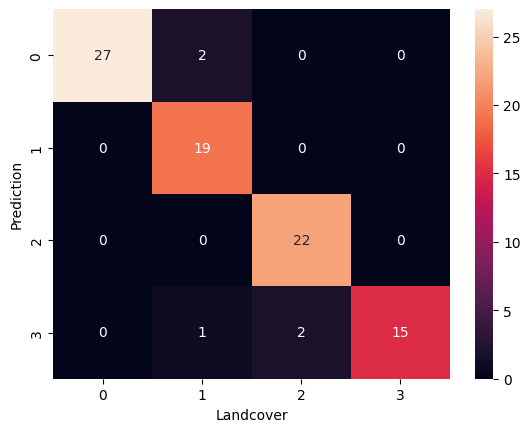

In [23]:
ax = sns.heatmap(cm.getInfo(), annot=True)
ax.set_xlabel('Landcover')
ax.set_ylabel('Prediction');

## Exercise

Calculate and print the following assessment metrics
1. Producer's accuracy
2. Consumer's accuracy
3. F1-score

In [24]:
## Overall accuracy
cm.accuracy()

In [25]:
cm.consumersAccuracy()

In [26]:
cm.producersAccuracy().getInfo()

[[0.9310344827586207], [1], [1], [0.8333333333333334]]

## Improving the classification model

1. **Cloud masking** - [Cloud masking with cloud score](https://medium.com/google-earth/all-clear-with-cloud-score-bd6ee2e2235e)
2. **Feature engineering** - introduce new features like NDVI, NDBI etc to enable the model to better learn from the images
3. **Add Elevation and Slope**: We also add slope and elevation bands from the ALOS DEM
4. **Normalize the Inputs**: Machine learning models work best when all the inputs have the same scale. We will divide each band with the maximum value. This method ensures that all input values are between 0-1. A more complete and robust technique for image normalization is provided in the course Supplement.

In [27]:
## Get the sentinel image collection
s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED')

## Filter the image collection
filtered = s2.filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE",30))\
.filter(ee.Filter.date('2023-01-01','2024-01-01'))\
.filter(ee.Filter.bounds(geometry))

## Extract the area of interest
basin = ee.FeatureCollection('WWF/HydroSHEDS/v1/Basins/hybas_7')
arkavathy = basin.filter(ee.Filter.eq('HYBAS_ID', 4071139640))
geometry = arkavathy.geometry()

### Cloud masking with Cloud Score+

In [28]:
## Load the cloud score+ image collection
csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')
csPlusBands = csPlus.first().bandNames()
csPlusBands

we need to add the cloud score+ bands to each sentinel-2 image
To acheive that, we use `linkCollection()` function

In [29]:
filtered_csPlus = filtered.linkCollection(csPlus, csPlusBands)
## Check if the bands cs and cs_cdf are added or not:
filtered_csPlus.first().bandNames()

Now we will mask the pixels with low CS+ QA scores

In [30]:
def maskLowQA(image):
    qaBand = 'cs'
    clearThreshold = 0.5
    mask = image.select(qaBand).gte(clearThreshold)
    return image.updateMask(mask)

## Apply the mask function to image collection
filteredMasked = filtered_csPlus.map(maskLowQA).select('B.*')

Now since we have removed the outliers like clouds, cloud shadows, we will determine the composite of the image

In [31]:
composite = filteredMasked.median().clip(geometry)

In [32]:
Map = geemap.Map()
Map.addLayer(composite, rgbVis, 'image')
Map.centerObject(geometry, zoom=10)
Map

Map(center=[12.8376291976128, 77.44795130277099], controls=(WidgetControl(options=['position', 'transparent_bg…

Now we have cleaned the image using cloud score+. This will definitely improved our classification model

## Add more indices to the input

Add additional bands like NDVI, NDWI etc as inputs. This will allow model to learn more about each pixel beyond the existing bands of sentinel-2 (B1, B2....etc)

In [33]:
def addIndices(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('ndvi')
    ndbi = image.normalizedDifference(['B11', 'B8']).rename('ndbi')
    mndwi = image.normalizedDifference(['B3', 'B11']).rename('mndwi')
    bsi = image.expression(
        '((X+Y) - (A+B)) / ((X+Y)+(A+B))', {
            'X': image.select("B11"), ## swirl
            'Y': image.select('B4'), ##red
            'A': image.select('B8'), ## NIR
            'B': image.select('B2') ## blue
        }
    ).rename('bsi')

    return image.addBands(ndvi).addBands(ndbi).addBands(mndwi).addBands(bsi)

## Add the additional bands
composite = addIndices(composite)
composite.bandNames()

## Add slope and Elevation data



In [34]:
alos = ee.ImageCollection('JAXA/ALOS/AW3D30/V3_2')

elevation = alos.select('DSM').mosaic().rename('elev')
slope = ee.Terrain.slope(elevation).rename('slope')

composite = composite.addBands(elevation).addBands(slope)

## Normalize the image

Pixel Values should be between 0 and 1, that enables model to learn from the training in an unbiased way

Formula is $$\frac{(x - x_{min})}{ (x_{max} - x_{min})}$$

In [35]:
def normalized(image):

    bandNames = image.bandNames()

    minDict = image.reduceRegion(
        reducer = ee.Reducer.min(),
        geometry = geometry,
        scale = 100,
        maxPixels=1e9,
        bestEffort = True,
        tileScale = 16
    )

    maxDict = image.reduceRegion(
        reducer = ee.Reducer.max(),
        geometry =  geometry,
        scale = 100,
        maxPixels = 1e9,
        bestEffort = True,
        tileScale = 16
    )


    mins = ee.Image.constant(minDict.values(bandNames));
    maxs = ee.Image.constant(maxDict.values(bandNames));

    normalized = image.subtract(mins).divide(maxs.subtract(mins));
    return normalized

composite = normalized(composite)

## Training

Now the composite is ready for training

In [36]:
## Create a random column which will assign a float number to each feature with uniform distribution
gcps = gcp.randomColumn()
train_test_split = 0.8
trainGCP = gcps.filter(ee.Filter.lt('random', train_test_split))
testGCP = gcps.filter(ee.Filter.gte('random',train_test_split))

training = composite.sampleRegions(
    collection = trainGCP,
    properties = ['landcover'],
    scale=10,
    tileScale=16
)

classifier = ee.Classifier.smileRandomForest(50).train(
    features = training, ## Are the feature collection with labels
    classProperty = 'landcover',
    inputProperties = composite.bandNames()
)

## After training, now classify all the pixels from the composite and visualize
classified = composite.classify(classifier)

In [37]:
test = classified.sampleRegions(
    collection = testGCP,
    properties = ['landcover'],
    scale = 10,
    tileScale = 16
)

In [38]:
cm = test.errorMatrix('landcover', 'classification')
cm

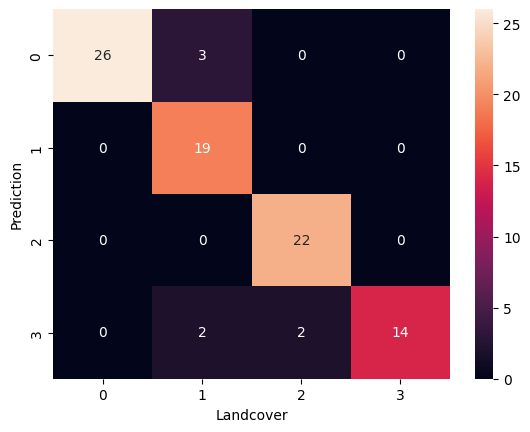

In [39]:
ax = sns.heatmap(cm.getInfo(), annot=True)
ax.set_xlabel('Landcover')
ax.set_ylabel('Prediction');

In [40]:
## Overall accuracy
cm.accuracy()

## Exporting the Image

why exporting an Image ?

The google earth engine sets a time limit of 5 mins for any computation. If it exceeds then it will throw an error. To overcome this we need to export the image using batch computation.

if using `geemap.export` function

```python
geemap.ee_export_image(
    classified.clip(geometry).unmask(),
    filename='classified.tif',
    scale=90,
    region=geometry,
    file_per_band=False
)
```
That notebook is using the `geemap.ee_export_image_collection` function which uses `geemap.ee_export_image` which itself calls `ee.Image.getDownloadURL` under the hood. According to the documentation for this function, the maximum request size is 32 MB:

> Get a download URL for small chunks of image data in GeoTIFF or NumPy format. Maximum request size is 32 MB, maximum grid dimension is 10000.

You may get this error

```
Generating URL ...
Downloading data from https://earthengine.googleapis.com/v1/projects/kavyajeetbora-ee/thumbnails/86273f8803fbdc633b12f85ae82f5d0a-32fceba7d974ac5ef19b70086ae07db0:getPixels
Please wait ...
An error occurred while downloading.
```

A better option is to create an Export task:

https://developers.google.com/earth-engine/guides/exporting_images

In geemap, you also have some functions that wrap this for you, e.g. geemap.`ee_export_image_to_drive`


In [41]:
# Export the image, specifying the CRS, transform, and region.
task = ee.batch.Export.image.toDrive(
    image = classified,
    region = geometry,
    scale = 10,
    maxPixels = 1e10
)

task.start()

The task will take some time depending on the amount of computation and export it to drive.

If we want to export some metrics like accuracy, confusion matrix etc that may take a long time to compute, we can use export

But google earth engine can export only ImageCollection, Image, feature and feature collection object only.

The workaround is to export the metrics as a featurecollection object.

we will use `ee.batch.Export.table.toDrive()` function. You can find the relevant [docs](https://developers.google.com/earth-engine/apidocs/export-table-todrive)

In [42]:
fc = ee.FeatureCollection([ee.Feature(
    None,
    {
        'accuracy': cm.accuracy(),
        'matrix': cm.array()
    }
)])

## Now export it to drive
## Note: Donot print it otherwise it will timeout if it is a very large computation

task = ee.batch.Export.table.toDrive(
    collection = fc,
    description = 'Evaluation Metrics',
    folder = 'gee_exports',
    fileFormat = 'CSV',
)

task.start()

Then you can mount your drive with this notebook and use the computation results for reporting:

In [43]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [44]:
df = pd.read_csv('/gdrive/My Drive/gee_exports/Evaluation Metrics.csv')
df

,system:index,accuracy,matrix,.geo
0,0,0.920455,"[[26, 3, 0, 0], [0, 19, 0, 0], [0, 0, 22, 0], ...","{""type"":""MultiPoint"",""coordinates"":[]}"


Now extract the values and plot the confusion matrix

Accuracy of the model is 92.05 %


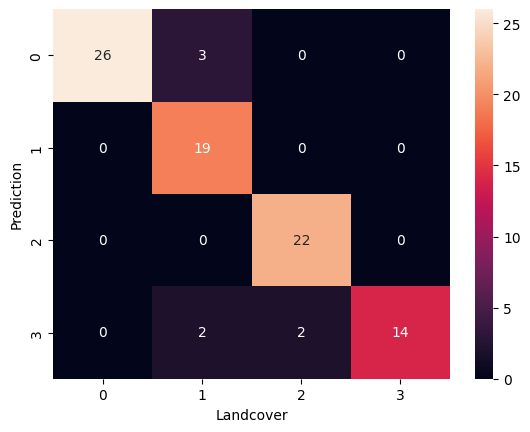

In [45]:
## extract the text representation of the confusion matrix
## and convert it to python list
cm = eval(df['matrix'].iloc[0])

## Extract the accuracy
acc = float(df['accuracy'].iloc[0])*100

print(f"Accuracy of the model is {acc:.2f} %")
ax = sns.heatmap(cm, annot=True)
ax.set_xlabel('Landcover')
ax.set_ylabel('Prediction');

## Note on Image Pyramids

<img src='https://developers.google.com/static/earth-engine/images/Pyramids.png' height=300/>

Image assets in Earth Engine exist at multiple scales, in image pyramids. The pyramiding policy determines how each pixel at a given level of the pyramid is computed from the aggregation of a 2x2 block of pixels at the next lower level. For continuous valued images, the pixel values of upper levels of the pyramid are the mean of pixels at the next lower level. For discrete valued images, pixel values of upper levels of the pyramid are a sample (usually the top left pixel) of pixels at the next lower level.

The lowest level of the image pyramid represents image data at native resolution, when it is ingested into Earth Engine. During ingestion, the data are aggregated (according to the pyramiding policy) to create higher pyramid levels. The data are aggregated until the entire image fits within a 256x256 pixel tile. When you use an image in your code, Earth Engine chooses a level of the pyramid with the closest scale less than or equal to the scale specified by your analysis and resamples (using nearest neighbor by default) as necessary

Reference

1. [Pyramid Levels in google earth engine](https://developers.google.com/earth-engine/guides/scale)



In [46]:
image = ee.Image('LANDSAT/LC08/C02/T1_TOA/LC08_044034_20140318').select('B4')

def printAtScale(scale):

    pixel_val = image.reduceRegion(
        reducer = ee.Reducer.first(),
        geometry = image.geometry().centroid(),
        scale = scale
    ).get('B4').getInfo()

    print(f'Pixel value at {scale} is {pixel_val}')

for i in [10,30,50,70,200,500]:
    x = printAtScale(i)

Pixel value at 10 is 0.10394100844860077
Pixel value at 30 is 0.10394100844860077
Pixel value at 50 is 0.09130698442459106
Pixel value at 70 is 0.1150854229927063
Pixel value at 200 is 0.102478988468647
Pixel value at 500 is 0.09072770178318024


You can see that the pixel value changes with scale due to the fact that different pyramid levels are selected for different levels. The important point is that by varying the scale, different image inputs are requested

## Using WorldCover for land cover classification

In [49]:
world_cover = ee.ImageCollection("ESA/WorldCover/v100")
classification = ee.Image(world_cover.first())

## Area of interest
adm = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2")
delhi = adm.filter(ee.Filter.eq('ADM1_NAME', "Delhi"))
geometry = delhi.geometry()

## Plot on map
Map = geemap.Map()
Map.addLayer(classification.clip(geometry))
Map.centerObject(geometry, zoom=11)
Map

Map(center=[28.64654955564474, 77.10895454636062], controls=(WidgetControl(options=['position', 'transparent_b…

Plot the water bodies only

In [50]:
water = classification.eq(80)

## Plot on map
Map = geemap.Map()
Map.addLayer(water.clip(geometry), {'min':0, 'max':1, 'palette': ['white', 'blue']})
Map.centerObject(geometry, zoom=11)
Map

Map(center=[28.64654955564474, 77.10895454636062], controls=(WidgetControl(options=['position', 'transparent_b…

## Calculating the area


In [52]:
## Calculate vector area

area = geometry.area().getInfo()

print(f"Area of Delhi: {area:.2f} m2")
print(f"Area of Delhi: {area/1e6:.2f} km2")

Area of Delhi: 1504399648.06 m2
Area of Delhi: 1504.40 km2


Specify the projection to get uniform results over different software:

In [57]:
area = geometry.area(
    maxError = 0.1,
    proj = 'EPSG:32643'
)
area

**Raster area calculation**

Calculate the area of water:

In [64]:
ee.Image.pixelArea().getInfo()

{'type': 'Image',
 'bands': [{'id': 'area',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

In [66]:
water = classification.eq(80)

## Calculate the area of each pixel:
areaImage = water.multiply(ee.Image.pixelArea())

## Sum up the each pixel area
totalArea = areaImage.reduceRegion(
    reducer = ee.Reducer.sum(),
    geometry = geometry,
    scale=10,
    maxPixels = 1e10,
    tileScale=16
)

totalArea

In [67]:
## Format the area into km2
totalArea.getNumber('Map').divide(1e6)